No backend selected.
Finding available backend...


Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Found pytorch
Setting the default backend to "pytorch". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Compiling model...
'compile' took 10.565025 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [2.46e-01]    [2.10e-01]    [1.00e+00]    
1000      [4.50e-04]    [3.92e-04]    [4.33e-02]    
2000      [9.10e-05]    [1.18e-04]    [2.38e-02]    
3000      [2.71e-05]    [6.09e-05]    [1.71e-02]    
4000      [2.89e-06]    [3.49e-05]    [1.29e-02]    
5000      [4.08e-07]    [3.13e-05]    [1.22e-02]    
6000      [2.08e-07]    [3.01e-05]    [1.20e-02]    
7000      [4.61e-05]    [8.25e-05]    [1.99e-02]    
8000      [1.13e-05]    [4.32e-05]    [1.44e-02]    
9000      [1.09e-07]    [2.81e-05]    [1.16e-02]    
10000     [2.72e-06]    [2.88e-05]    [1.18e-02]    

Best model at step 9000:
  train loss: 1.09e-07
  

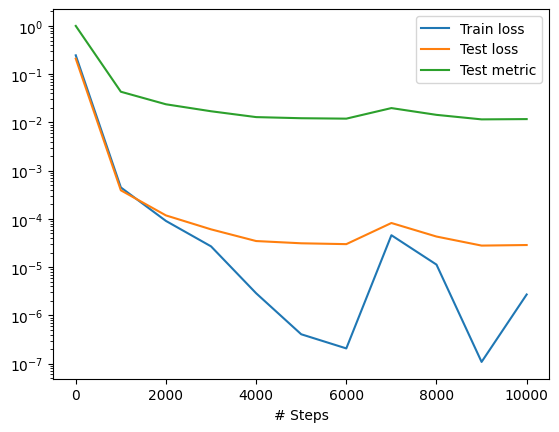

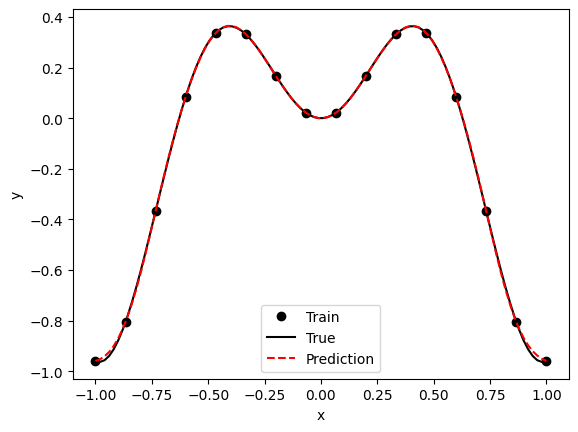

In [1]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle"""
import deepxde as dde
import numpy as np


def func(x):
    """
    x: array_like, N x D_in
    y: array_like, N x D_out
    """
    return x * np.sin(5 * x)


geom = dde.geometry.Interval(-1, 1)
num_train = 16
num_test = 100
data = dde.data.Function(geom, func, num_train, num_test)

activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN([1] + [20] * 3 + [1], activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=10000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Burgers equation with residual-based adaptive refinement

Compiling model...
'compile' took 0.000558 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [4.49e-02, 1.92e-02, 4.58e-01]    [4.49e-02, 1.92e-02, 4.58e-01]    []  
1000      [3.97e-02, 1.05e-03, 5.68e-02]    [3.97e-02, 1.05e-03, 5.68e-02]    []  
2000      [3.02e-02, 2.47e-04, 4.08e-02]    [3.02e-02, 2.47e-04, 4.08e-02]    []  
3000      [1.95e-02, 1.21e-04, 2.07e-02]    [1.95e-02, 1.21e-04, 2.07e-02]    []  
4000      [1.48e-02, 9.89e-05, 8.28e-03]    [1.48e-02, 9.89e-05, 8.28e-03]    []  
5000      [9.29e-03, 7.22e-05, 4.63e-03]    [9.29e-03, 7.22e-05, 4.63e-03]    []  
6000      [6.30e-03, 4.97e-05, 2.98e-03]    [6.30e-03, 4.97e-05, 2.98e-03]    []  
7000      [4.54e-03, 3.30e-05, 2.11e-03]    [4.54e-03, 3.30e-05, 2.11e-03]    []  
8000      [3.60e-03, 3.03e-05, 1.63e-03]    [3.60e-03, 3.03e-05, 1.63e-03]    []  
9000      [3.09e-03, 3.03e-05, 1.38e-03]    [3.09e-03, 3.03e-05, 1.38e-03]    []  
10000     [2.70

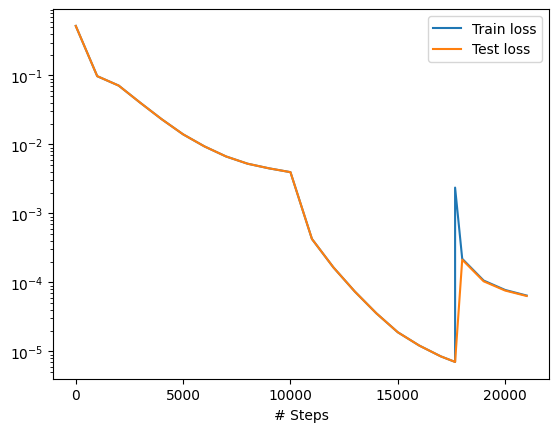

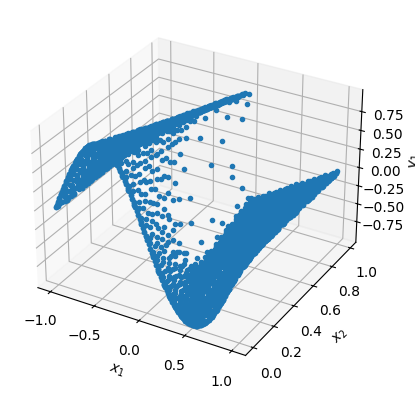

Mean residual: 0.0045157503
RAR L2 relative error: 0.01938830371979423


In [16]:
# pinn_rar.py
"""Solve Burgers’ eqn with RAR (residual-based adaptive refinement)."""
import deepxde as dde
import numpy as np

# 0. Fix seed for reproducibility
dde.config.set_random_seed(1234)

# 1. Exact test data loader
def gen_testdata():
    data = np.load("Burgers.npz")
    t, x, exact = data["t"], data["x"], data["usol"].T
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((xx.ravel(), tt.ravel())).T
    y = exact.flatten()[:, None]
    return X, y

# 2. Burgers’ PDE residual
def pde(x, y):
    dy_x  = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t  = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y,    x, i=0, j=0)
    return dy_t + y * dy_x - 0.01 / np.pi * dy_xx

# 3. Geometry & BC/IC
geom       = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 0.99)
geomtime   = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.icbc.DirichletBC(
    geomtime, lambda x: 0, lambda _, on_boundary: on_boundary
)
ic = dde.icbc.IC(
    geomtime, lambda x: -np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial
)

# 4. Data object (fixed initial collocation)
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=2500,
    num_boundary=100,
    num_initial=160,
)

# 5. Network & Model
net   = dde.nn.FNN([2, 20, 20, 20, 1], "tanh", "Glorot normal")
model = dde.Model(data, net)

# 6. Initial training: Adam → L-BFGS
model.compile("adam", lr=1e-3)
losshistory, _ = model.train(iterations=10000)

model.compile("L-BFGS")
_, train_state = model.train()

# 7. RAR loop: add one worst point at a time until residual < 5e-3
X_cand = geomtime.random_points(100000)
err = 1.0
while err > 5e-3:
    res = model.predict(X_cand, operator=pde)
    err_each = np.abs(res).flatten()
    err = err_each.mean()
    print(f"Current mean residual = {err:.3e}")

    # add worst point
    idx = np.argmax(err_each)
    data.add_anchors(X_cand[idx : idx + 1])

    # re-train Adam (with early stopping), then L-BFGS
    early_stop = dde.callbacks.EarlyStopping(min_delta=1e-4, patience=2000)
    model.compile("adam", lr=1e-3)
    model.train(
        iterations=10000,
        disregard_previous_best=True,
        callbacks=[early_stop],
    )
    model.compile("L-BFGS")
    losshistory, train_state = model.train()

# 8. Plot & save all history
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

# 9. Final evaluation
X_test, y_true = gen_testdata()
y_pred = model.predict(X_test)
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("RAR L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))

# 10. Export
np.savetxt("test_rar.dat", np.hstack((X_test, y_true, y_pred)))


Regular PINN Solution (no RAR)

Compiling model...
'compile' took 0.000343 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.35e-01, 6.24e-02, 5.25e-01]    [2.35e-01, 6.24e-02, 5.25e-01]    []  
1000      [4.21e-02, 1.41e-03, 5.80e-02]    [4.21e-02, 1.41e-03, 5.80e-02]    []  
2000      [3.17e-02, 2.12e-04, 4.64e-02]    [3.17e-02, 2.12e-04, 4.64e-02]    []  
3000      [1.80e-02, 1.19e-04, 2.04e-02]    [1.80e-02, 1.19e-04, 2.04e-02]    []  
4000      [8.78e-03, 6.74e-05, 6.35e-03]    [8.78e-03, 6.74e-05, 6.35e-03]    []  
5000      [3.70e-03, 1.77e-05, 3.26e-03]    [3.70e-03, 1.77e-05, 3.26e-03]    []  
6000      [2.54e-03, 1.21e-05, 2.21e-03]    [2.54e-03, 1.21e-05, 2.21e-03]    []  
7000      [2.02e-03, 9.17e-06, 1.81e-03]    [2.02e-03, 9.17e-06, 1.81e-03]    []  
8000      [1.68e-03, 8.34e-06, 1.49e-03]    [1.68e-03, 8.34e-06, 1.49e-03]    []  
9000      [1.83e-03, 7.80e-06, 1.27e-03]    [1.83e-03, 7.80e-06, 1.27e-03]    []  
10000     [1.39

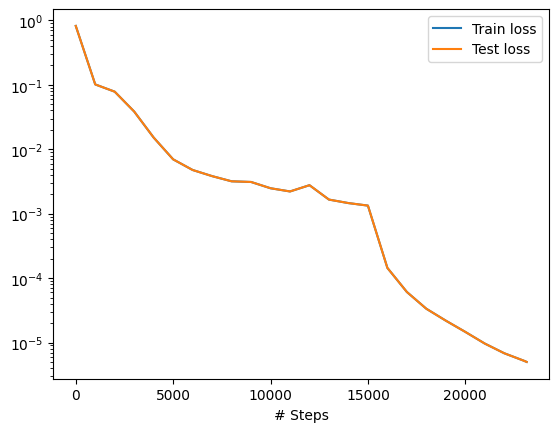

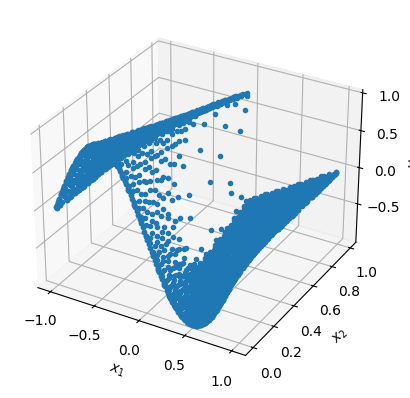

Mean residual: 0.0076484787
L2 relative error: 0.03505024919055079


In [14]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""

import deepxde as dde
import numpy as np


def gen_testdata():
    data = np.load("Burgers.npz")
    t, x, exact = data["t"], data["x"], data["usol"].T
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y


def pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t + y * dy_x - 0.01 / np.pi * dy_xx


geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 0.99)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(
    geomtime, lambda x: -np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial
)

data = dde.data.TimePDE(
    geomtime, pde, [bc, ic], num_domain=2540, num_boundary=80, num_initial=160
)
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

model.compile("adam", lr=1e-3)
model.train(iterations=15000)
model.compile("L-BFGS")
losshistory, train_state = model.train()
# """Backend supported: pytorch"""
# # Run NNCG after Adam and L-BFGS
# dde.optimizers.set_NNCG_options(rank=50, mu=1e-1)
# model.compile("NNCG")
# losshistory, train_state = model.train(iterations=1000, display_every=100)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

X, y_true = gen_testdata()
y_pred = model.predict(X)
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))

RAR for Helmholtz equation

Compiling model...
'compile' took 0.000316 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.52e+01, 1.00e+00, 5.36e-01]    [1.52e+01, 1.00e+00, 5.36e-01]    []  
1000      [1.88e-02, 9.81e-01, 9.81e-01]    [1.88e-02, 9.81e-01, 9.81e-01]    []  
2000      [1.89e-02, 9.79e-01, 9.82e-01]    [1.89e-02, 9.79e-01, 9.82e-01]    []  
3000      [1.91e-02, 9.76e-01, 9.81e-01]    [1.91e-02, 9.76e-01, 9.81e-01]    []  
4000      [3.86e-02, 2.58e-01, 2.98e-01]    [3.86e-02, 2.58e-01, 2.98e-01]    []  
5000      [7.58e-03, 2.76e-03, 4.46e-04]    [7.58e-03, 2.76e-03, 4.46e-04]    []  

Best model at step 5000:
  train loss: 1.08e-02
  test loss: 1.08e-02
  test metric: []

'train' took 11.563957 s

Compiling model...
'compile' took 0.000239 s

Training model...

Step      Train loss                        Test loss                         Test metric
5000      [7.58e-03, 2.76e-03, 4.46e-04]    [7.58e-03, 2.76e-03, 4.46e-04]  

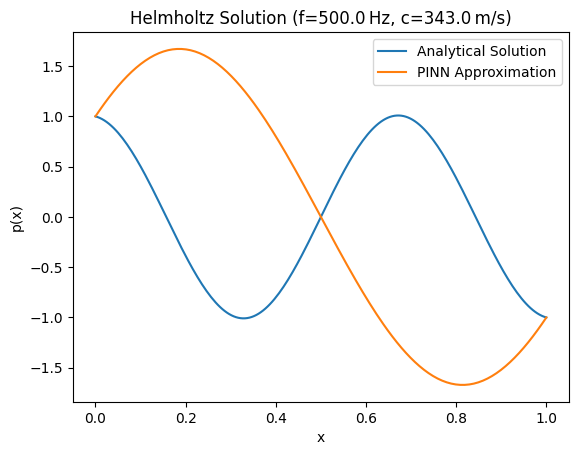

Saving loss history to c:\Users\gauta\OneDrive\Desktop\Deep Learning\loss.dat ...
Saving training data to c:\Users\gauta\OneDrive\Desktop\Deep Learning\train.dat ...
Saving test data to c:\Users\gauta\OneDrive\Desktop\Deep Learning\test.dat ...


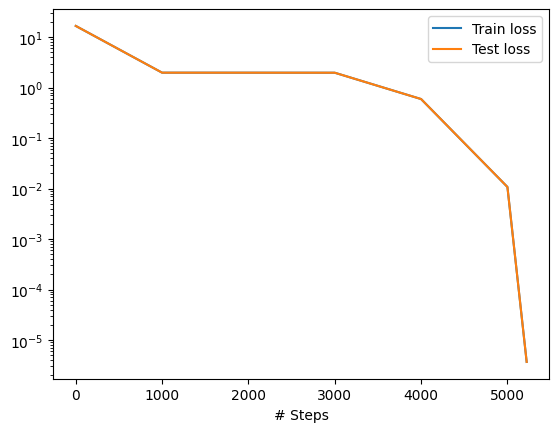

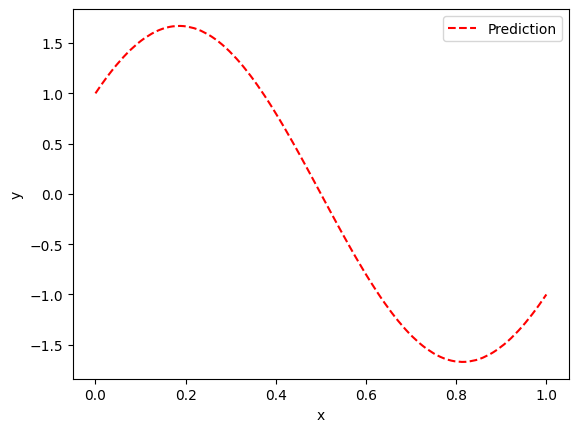

Saved solution to helmholtz_solution.dat


In [4]:
import deepxde as dde
import numpy as np

# Physical parameters
L = 1.0          # length of the duct
k = 5.0          # wavenumber (e.g. omega/c)
p1 = 1.0         # p(0)
p2 = -1.0        # p(L)

# Define the PDE: d2p/dx2 + k^2 p = 0
def helmholtz_pde(x, p):
    # x has shape (N, 1), p has shape (N, 1)
    dp_xx = dde.grad.hessian(p, x, i=0, j=0)
    return dp_xx + k**2 * p

# Geometry: 1D interval [0, L]
geom = dde.geometry.Interval(0.0, L)

# Boundary conditions: Dirichlet at x=0 and x=L
bc_left = dde.icbc.DirichletBC(geom, lambda x: p1, lambda x, on_bnd: on_bnd and np.isclose(x[0], 0.0))
bc_right = dde.icbc.DirichletBC(geom, lambda x: p2, lambda x, on_bnd: on_bnd and np.isclose(x[0], L))

# PDE data: no initial condition or time domain needed
data = dde.data.PDE(
    geom,
    helmholtz_pde,
    [bc_left, bc_right],
    num_domain=100,    # interior collocation points
    num_boundary=2,    # two boundary points
)

# Neural network: input dim = 1, output dim = 1
net = dde.nn.FNN([1] + [20]*3 + [1], "tanh", "Glorot normal")

model = dde.Model(data, net)

# Training
model.compile("adam", lr=1e-3)
model.train(iterations=5000)

model.compile("L-BFGS")
losshistory, train_state = model.train()

import numpy as np
import matplotlib.pyplot as plt

# --- Physical / boundary parameters ---
f = 500.0       # frequency in Hz (choose as needed)
c = 343.0       # speed of sound in m/s
L = 1.0         # length of the duct
p1 = 1.0        # p(0)
p2 = -1.0       # p(L)

# Compute wavenumber
k = 2 * np.pi * f / c

# Analytical solution on a fine grid
x = np.linspace(0, L, 200)[:, None]
A = p1
B = p2
p_true = (
    A * np.cos(k * x)
    + ((B - A * np.cos(k * L)) / np.sin(k * L)) * np.sin(k * x)
)

# PINN prediction (assumes `model` is your trained DeepXDE Model)
p_pinn = model.predict(x)

# Plot
plt.plot(x, p_true, label="Analytical Solution")
plt.plot(x, p_pinn, label="PINN Approximation")
plt.xlabel("x")
plt.ylabel("p(x)")
plt.title(f"Helmholtz Solution (f={f} Hz, c={c} m/s)")
plt.legend()
plt.show()


# Plot losses
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

# Predict on a fine grid and save
X = np.linspace(0, L, 200)[:, None]
p_pred = model.predict(X)
np.savetxt("helmholtz_solution.dat", np.hstack((X, p_pred)))
print("Saved solution to helmholtz_solution.dat")
